# Coupled 1.1: Water uptake by a single root

We compare the solutions of the different numerical codes that implemented 
the benchmarking problem C1.1. 

* [Dumux](Single root water uptake - Dumux.ipynb)

In particular, we compare the shape and time of the water potential versus radius curve at the onset of stress. 
For an automatic comparison of the numerical results, save the results in a text file, each result consisting of two rows containing comma separated radial distance values [cm] in the first, and matric potential [cm] in the second. This is done for each soil and transpiration rate scenario (i.e. 3 (soils) * 2 (transpiration rate) results = 6 rows). The files need to be located in the folder /C1.1 Numerical results/.


In [18]:
import numpy as np
from scipy import optimize
from scipy import integrate
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import os
import ast
from van_genuchten import *

In [19]:
#sand = Parameters(0.02, 0.46, 0.0144, 1.534, 15.42, -0.215) 
#loam = Parameters(0.01, 0.42, 0.0084, 1.441, 12.98, -1.497)
#clay = Parameters(0.01, 0.59, 0.0195, 1.109, 4.53, -5.901)
sand = Parameters(0.045, 0.43, 0.15, 3, 1000,0.5) 
loam = Parameters(0.08, 0.43, 0.04, 1.6, 50,0.5) 
clay = Parameters(0.1, 0.4, 0.01, 1.1, 10,0.5) 

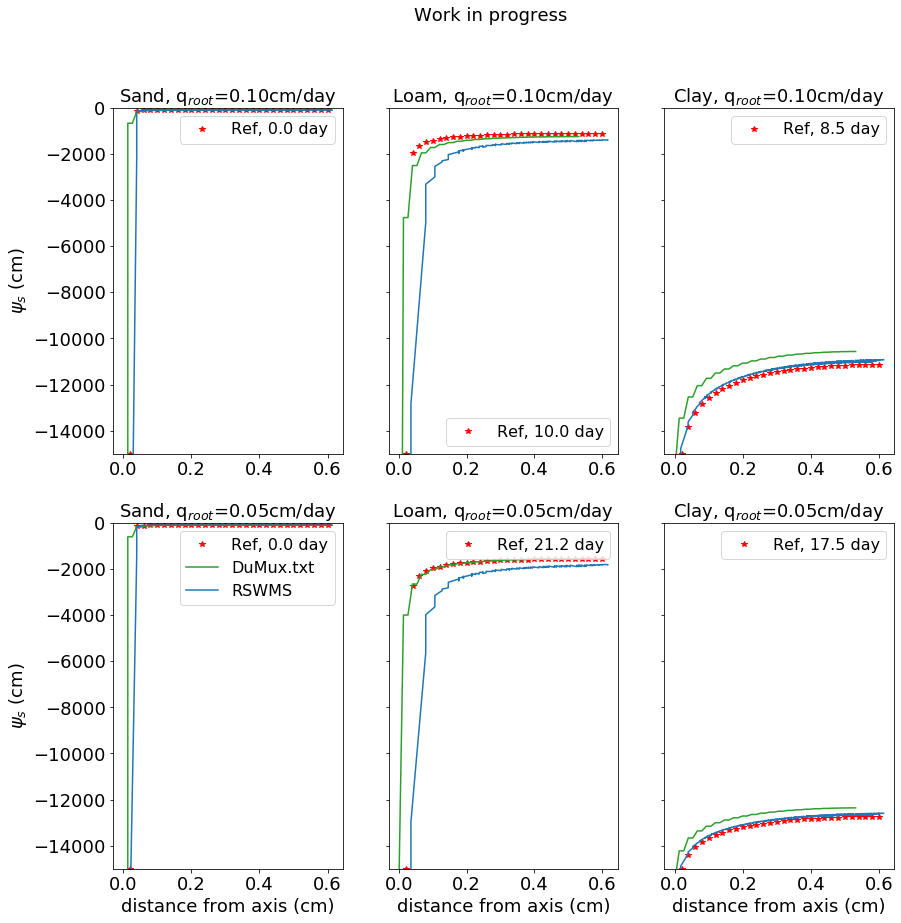

In [22]:
r_root = 0.02   # cm
r_out = 0.6        #cm
rho = r_out/r_root
h_out = np.linspace(-100,-14500,100);   #cm
h_lim = -15000   # cm
q_out = 0#q_root * (r_root/(2*r_out))
r = np.linspace(r_root, r_out, 30)
fig, ax = plt.subplots(2, 3,figsize=(14, 14))
h_stressonset = np.zeros((6,len(r))); wc_stressonset = np.zeros((6,len(r)));
ind=0; soils=["Sand", "Loam", "Clay"];
for s,soil in enumerate([sand, loam, clay]): 
    for q,q_root in enumerate([0.1,0.05]):    # q_root in [cm/d], high and low transpiration
        crit=0; k=0;
        while crit < 1:
            MFP_nostress = MFP(h_out[k],soil) + (q_root*r_root-q_out*r_out)*(r**2/r_root**2/(2*(1-rho**2))+rho**2/(1-rho**2)*(np.log(r_out/r)-0.5)) + q_out*r_out*np.log(r/r_out)
            if np.amin(MFP_nostress)<=0:   #stress   
                MFP_stress  = (MFP(h_out[k],soil)+q_out*r_out*np.log(1/rho))*( (r**2/r_root**2 - 1 + 2*rho**2*np.log(r_root/r))/(rho**2 - 1+2*rho**2*np.log(1/rho)) ) + q_out*r_out*np.log(r/r_root)
                for i in range(len(r)):        
                    h_stressonset[ind,i] = h(MFP_stress[i],soil) 
                    wc_stressonset[ind,i] = water_content(h_stressonset[ind,i],soil)
                crit=crit+1
                #print(crit)#(h_stressonset.shape)
            k=k+1;
        # plot
        Q = np.trapz(wc_stressonset[ind,:]*r,r)
        simtime=((r_out**2-r_root**2)*3.14*water_content(-100,soil) - Q*2*3.14)/(2*r_root*3.14*q_root)
        ax[int(q),int(s)].plot(r,h_stressonset[ind,:],'r*',label='Ref, '+"{:.1f}".format(simtime)+" day")
        ax[1,int(s)].set_xlabel("r (cm)")
        ax[int(q),0].set_ylabel("$\\psi_s$ (cm)")
        ax[int(q),1].set_yticklabels([]);ax[int(q),2].set_yticklabels([])
        ax[int(q),int(s)].set_ylim(-15000,0)
        ax[int(q),int(s)].legend() 
        ax[int(q),int(s)].title.set_text(soils[int(s)]+r', q$_{root}$='+"{:.2f}".format(q_root)+"cm/day")
        ind=ind+1;
        
# Numerical solutions
r, nrmse, nn, l, lsoil, lqroot = [], [], [], [], [], []
cc = 0
col=["C2","C0","b"]; lsoils=["Sand","Loam","Clay"]; lqroots=[0.1,0.05]
for dirname, dirnames, filenames in os.walk('C1.1 Numerical results/.'):    
    filenames.sort()
    for i,f in enumerate(filenames):            
        try:        
            data = []
            with open('C1.1 Numerical results/'+f) as fp: 
                for line in fp:
                    s = ast.literal_eval("["+line+"]")                
                    data.append(s)    
            for k in range(0,3): # axis
                for j in range(0,2): 
                    l.append(f) 
                    lsoil.append(lsoils[k]) 
                    lqroot.append(lqroots[j])             
                    r_n = data[2*(3*j+k)]
                    h_n = data[2*(3*j+k)+1]  
                    nn.append(len(h_n))                     
                    pl, = ax[j,k].plot(r_n,h_n,col[cc]) # numeric solution 
                    r_a = np.linspace(r_root, r_out, 30)
                    h_a = h_stressonset[3*j+k,:]
                    interp = interp1d(r_n,h_n, kind='linear',fill_value='extrapolate', bounds_error =False )
                    h_n = interp(sorted(r_a)) # numerical solution at points of analytical solution                                     
                    nrmse.append(nRMSE(h_a,h_n)) # calculate metrics                                          
                    if k==0:
                        pl.set_label(f)                                      
                ax[j,k].set_xlabel("distance from axis (cm)")
                if j==0: 
                    ax[j,k].set_ylabel("$\\psi_s$ (cm)") 
                ax[j,k].legend() 
            cc+=1                                  
        except Exception as ex:
            print("Something went wrong with file "+f)    
            print(ex)                   

plt.savefig('c11_results.png', dpi=300, bbox_inches = "tight") 
fig.suptitle("Work in progress")
plt.show()

In [ ]:
import pandas as pd 

data_ = np.array([l, lsoil, lqroot, nrmse])
data_ = np.array(data_.transpose())

df = pd.DataFrame(data_, columns = ['Name','Soil','qroot','nRSME'] ) # Create the pandas DataFrame 
df['qroot'] = df['qroot'].astype(float)
df['qroot'] = df['qroot'].map('{:,.2f}'.format)
df['nRSME'] = df['nRSME'].astype(float)
df['nRSME'] = df['nRSME'].map('{:,.4f}'.format)
df.style.set_table_styles(
[{'selector': 'tr:nth-of-type(odd)',
  'props': [('background', '#eee')]}, 
 {'selector': 'tr:nth-of-type(even)',
  'props': [('background', 'white')]},
 {'selector': 'th',
  'props': [('background', '#606060'), 
            ('color', 'white'),
            ('font-family', 'verdana')]},
 {'selector': 'td',
  'props': [('font-family', 'verdana')]},
]
).hide_index()

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

fig,ax = render_mpl_table(df, header_columns=0, col_width=2.0)
fig.savefig("table_c1l.png")